#Метрики оценки качества ответов модели GigaChat + RAG + self-asking


In [1]:
!pip install gspread -q
!pip install pandas -q

In [2]:
from getpass import getpass
import gspread
import pandas as pd

In [3]:
parh_to_jsom = getpass(prompt='Введите путь к json файлу доступа к таблице')

table_key = getpass(prompt='Введите ключ доступа к Google таблице')

Введите путь к json файлу доступа к таблице··········
Введите ключ доступа к Google таблице··········


In [4]:
# Авторизация в аккаунт Google и открытие таблицы
client = gspread.service_account(filename=parh_to_jsom)
table = client.open_by_key(table_key)
worksheet = table.worksheet('FAQ КИИ УЦСБ')

##BLEU score

In [5]:
import warnings
warnings.filterwarnings('ignore')

import nltk.translate.bleu_score as bleu

In [6]:
df_BLEU = pd.DataFrame(columns=['Без self-asking','Self-asking до вопроса', 'Self-asking после вопроса'])

df_BLEU

,Без self-asking,Self-asking до вопроса,Self-asking после вопроса


In [7]:
bleu_score = []
for i in range(3, 23):
    row_data = worksheet.row_values(i)
    base = row_data[5].split()

    for k in [3, 2, 4]:
        assumption = row_data[k]
        bleu_score.append(bleu.sentence_bleu(base, assumption))

    df_BLEU.loc[i-2] = bleu_score
    bleu_score = []

In [8]:
df_BLEU = df_BLEU.round(4)

df_BLEU.head(4)

,Без self-asking,Self-asking до вопроса,Self-asking после вопроса
1,0.0612,0.0962,0.0574
2,0.1226,0.1402,0.1111
3,0.1844,0.2042,0.1995
4,0.1575,0.2211,0.2212


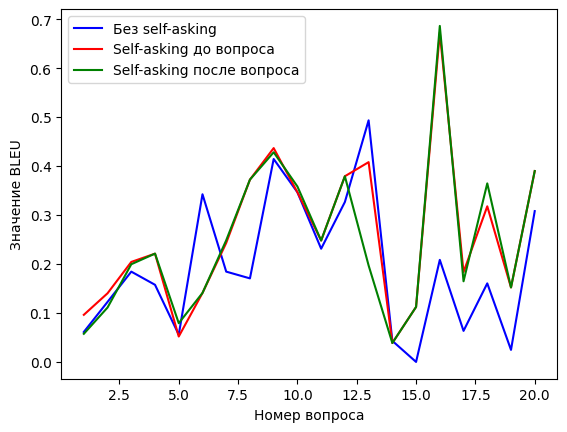

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(df_BLEU.index, df_BLEU.loc[:, 'Без self-asking'], label='Без self-asking', color='blue')
plt.plot(df_BLEU.index, df_BLEU.loc[:, 'Self-asking до вопроса'], label='Self-asking до вопроса', color='red')
plt.plot(df_BLEU.index, df_BLEU.loc[:, 'Self-asking после вопроса'], label='Self-asking после вопроса', color='green')

# Подписи осей
plt.xlabel('Номер вопроса')
plt.ylabel('Значение BLEU')

# Добавление легенды и отображение
plt.legend()
plt.show()

Чем больше значение BLEU, то есть чем выше идет линия графика, тем лучше ответ модели

In [10]:
sum = []
label = ["Без self-asking",	"Self-asking до вопроса", "Self-asking после вопроса"]
for column in df_BLEU.columns:
    # Складываем значения в столбце
    sum.append(df_BLEU[column].sum().round(4))

for x in range(len(sum)):
    sum[x] = round(sum[x]/len(df_BLEU), 4)
    print(f"{label[x]}: {sum[x]}")

Без self-asking: 0.1949
Self-asking до вопроса: 0.2577
Self-asking после вопроса: 0.2474


Видим, что наилучшие показатели имеет модель с Self-asking до вопроса

##BERT Transformer

Сходство предложений с помощью BERT Transformer

In [11]:
from transformers import BertTokenizer
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
df_BERT = pd.DataFrame(columns=['Без self-asking','Self-asking до вопроса', 'Self-asking после вопроса'])

df_BERT

,Без self-asking,Self-asking до вопроса,Self-asking после вопроса


In [13]:
# tokenizer = AutoTokenizer.from_pretrained("deepvk/USER-bge-m3")
# model = AutoModel.from_pretrained("deepvk/USER-bge-m3")

In [14]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')  # bert-base-uncased
model = BertModel.from_pretrained('bert-large-uncased')

# tokens = ['[CLS]'] + tokens1 + ['[SEP]'] + tokens2 + ['[SEP]']

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [15]:
bert_score = []
for i in range(3, 23):
    row_data_2 = worksheet.row_values(i)
    base_2 = row_data_2[5]

    for k in [3, 2, 4]:
        assumption_2 = row_data_2[k]

        # Tokenize the sentences
        tokens1 = tokenizer.tokenize(base_2)[:512]
        tokens2 = tokenizer.tokenize(assumption_2)[:512]

        # Load the BERT tokenizer and model
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained('bert-base-uncased')

        # Convert tokens to input IDs
        input_ids1 = torch.tensor(tokenizer.convert_tokens_to_ids(tokens1)).unsqueeze(0)  # Batch size 1
        input_ids2 = torch.tensor(tokenizer.convert_tokens_to_ids(tokens2)).unsqueeze(0)  # Batch size 1

        # Obtain the BERT embeddings
        with torch.no_grad():
            outputs1 = model(input_ids1)
            outputs2 = model(input_ids2)
            embeddings1 = outputs1.last_hidden_state[:, 0, :]  # [CLS] token
            embeddings2 = outputs2.last_hidden_state[:, 0, :]  # [CLS] token

        # Calculate similarity
        bert_score.append(cosine_similarity(embeddings1, embeddings2))

    df_BERT.loc[i-2] = bert_score
    bert_score = []

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
df_BERT = df_BERT.applymap(lambda x: round(x[0][0], 4))

df_BERT.head(4)

,Без self-asking,Self-asking до вопроса,Self-asking после вопроса
1,0.6187,0.6510,0.6356
2,0.8999,0.8718,0.8718
3,0.9246,0.8719,0.8607
4,0.8652,0.8913,0.9233


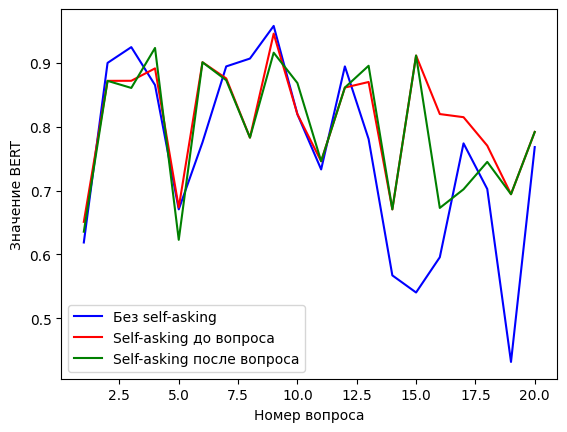

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(df_BERT.index, df_BERT.loc[:, 'Без self-asking'], label='Без self-asking', color='blue')
plt.plot(df_BERT.index, df_BERT.loc[:, 'Self-asking до вопроса'], label='Self-asking до вопроса', color='red')
plt.plot(df_BERT.index, df_BERT.loc[:, 'Self-asking после вопроса'], label='Self-asking после вопроса', color='green')

# Подписи осей
plt.xlabel('Номер вопроса')
plt.ylabel('Значение BERT')

# Добавление легенды и отображение
plt.legend()
plt.show()

Чем больше значение метрики BERT, то есть чем выше идет линия графика, тем лучше ответ модели

In [18]:
sum_2 = []
label = ["Без self-asking",	"Self-asking до вопроса", "Self-asking после вопроса"]
for column in df_BERT.columns:
    sum_2.append(df_BERT[column].sum().round(4))

for x in range(len(sum_2)):
    sum_2[x] = round(sum_2[x]/len(df_BERT), 4)
    print(f"{label[x]}: {sum_2[x]}")

Без self-asking: 0.756
Self-asking до вопроса: 0.8117
Self-asking после вопроса: 0.7973


Метрика BERT также показала, что наилучшие ответы имеет модель с Self-asking до вопроса